In [8]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
import mrmr
import optuna
import torch
import gpytorch
import torchmetrics

In [9]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))


In [4]:
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

Taken from "CSF biomarkers of Alzheimer’s disease concord with amyloid-β PET and predict clinical progression: A study of fully automated immunoassays in BioFINDER and ADNI cohorts"

In [5]:
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)

In [6]:
df['SUVr_Vermis_8.nii'].describe()

count    543.000000
mean       0.012274
std        0.001178
min        0.008156
25%        0.011467
50%        0.012260
75%        0.013009
max        0.015684
Name: SUVr_Vermis_8.nii, dtype: float64

In [7]:
df['tau_ab_ratio']

0      0.138289
1      0.416250
2      0.588928
3      0.183266
4      0.530144
         ...   
538    0.164647
539    0.179412
540    0.157882
541    0.176529
542    0.118140
Name: tau_ab_ratio, Length: 543, dtype: float64

In [11]:
df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

df.head()

,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,SUVr_Angular_R.nii,...,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,A+,T+,N+
0,-1.036305,-0.944252,-0.943637,-0.956548,0.039320,0.038841,0.011054,0.014155,-1.536236,-1.434771,...,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659,1,0,0
1,1.193040,1.119475,1.146182,0.929328,0.057261,0.053242,0.013008,0.017184,1.734375,2.031744,...,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699,1,1,1
2,1.485349,1.479118,1.520871,1.377067,0.054272,0.053113,0.013620,0.016730,1.583530,1.174492,...,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760,1,1,1
3,-0.076402,-0.117696,-0.401966,-0.095506,0.044834,0.042373,0.011938,0.015462,-0.681419,-0.333145,...,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675,1,0,0
4,-0.176979,-0.460626,-0.096761,-0.212546,0.042674,0.039067,0.011457,0.013684,-0.176115,-0.568854,...,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675,1,1,1


# SVM Model

In [60]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  

features = mrmr.mrmr_classif(X, y, K=25)

100%|██████████| 25/25 [00:00<00:00, 50.19it/s]


In [61]:
features[:25]

['SUVr_Precuneus_L.nii',
 'SUVr_Fusiform_L.nii',
 'SUVr_Precuneus_R.nii',
 'SUVr_Temporal_Mid_L.nii',
 'SUVr_ACC_pre_L.nii',
 'SUVr_Angular_L.nii',
 'SUVr_ACC_sub_L.nii',
 'SUVr_Temporal_Inf_L.nii',
 'SUVr_Fusiform_R.nii',
 'SUVr_Temporal_Mid_R.nii',
 'SUVr_Parietal_Sup_L.nii',
 'SUVr_Frontal_Med_Orb_L.nii',
 'SUVr_ACC_sub_R.nii',
 'SUVr_Parietal_Inf_L.nii',
 'SUVr_Temporal_Sup_R.nii',
 'SUVr_Olfactory_L.nii',
 'SUVr_Rectus_L.nii',
 'SUVr_Occipital_Mid_L.nii',
 'SUVr_Frontal_Med_Orb_R.nii',
 'SUVr_Angular_R.nii',
 'SUVr_Rectus_R.nii',
 'SUVr_Temporal_Sup_L.nii',
 'SUVr_ACC_pre_R.nii',
 'SUVr_Occipital_Inf_L.nii',
 'SUVr_Insula_R.nii']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

In [63]:
clf = SVC(kernel='sigmoid', C = 1, gamma = 0.001) 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [68]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))
print("MCC: ", matthews_corrcoef(y_test, y_pred))


Accuracy: 0.908256880733945
Precision: 0.96
Recall: 0.8571428571428571
F1 Score:  0.9081873315363882
MCC:  0.8219030920784135


In [69]:
confusion_matrix(y_test, y_pred)

array([[51,  2],
       [ 8, 48]])

In [70]:
y_scores = clf.decision_function(X_test)

roc_auc_score(y_test, y_scores)

0.9669811320754716

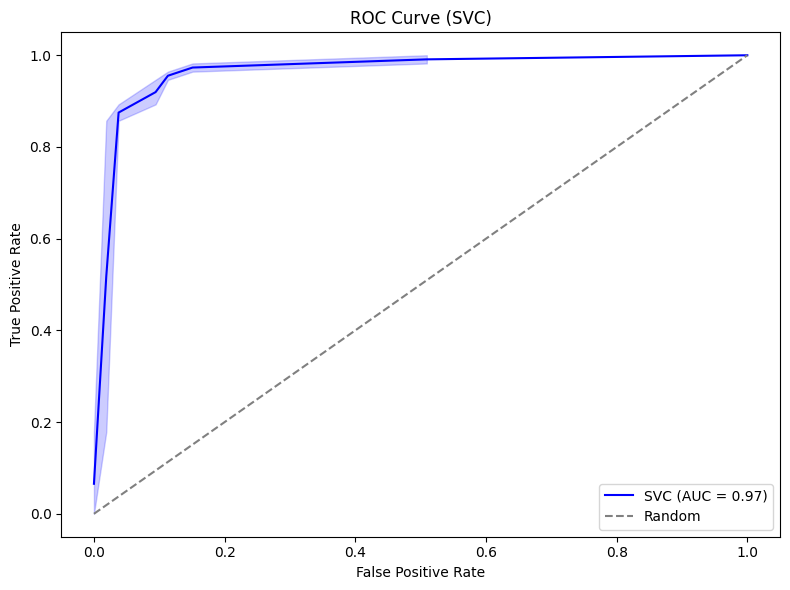

In [67]:
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f"SVC (AUC = {roc_auc:.2f})", color='blue')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVC)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# MultiOutput

In [272]:
y = df.filter(['A+', 'T+', 'N+'])


X = df.drop(columns=['A+', 'T+', 'N+'])
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns) 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =7)

clf = MultiOutputClassifier(SVC(C=1, gamma='scale', kernel='rbf'))

clf.fit(X_train, y_train)

,estimator,SVC(C=1)
,n_jobs,None
,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


In [273]:
y_pred = clf.predict(X_test)



In [274]:
for i, col in enumerate(y.columns):

    
    print(f"{col} accuracy: ",accuracy_score(y_pred[:,i], y_test[col]))

A+ accuracy:  0.8256880733944955
T+ accuracy:  0.926605504587156
N+ accuracy:  0.9357798165137615


# Optimisation

In [ ]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']  

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

clf = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-10)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV accuracy):", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=scal

# PCA 

In [ ]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+'] 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=df.drop(columns=['A+', 'T+', 'N+']).columns)  # Preserve column names




X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state =40)

pca = PCA(n_components=2)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)



In [ ]:
clf = SVC(kernel='sigmoid', C = 1, gamma = 0.001) 

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

In [14]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))


Accuracy: 0.8899082568807339
Precision: 0.9230769230769231
Recall: 0.8571428571428571


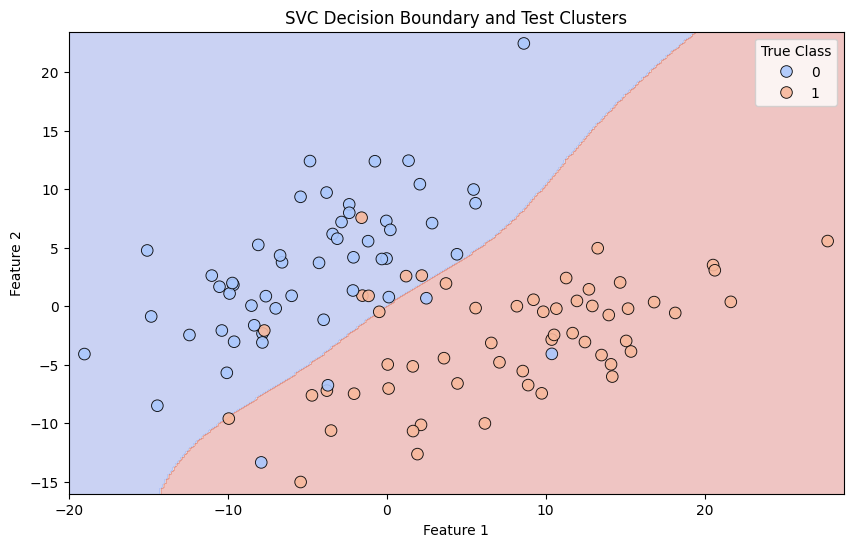

Accuracy: 0.908256880733945
Precision: 0.9259259259259259
Recall: 0.8928571428571429


In [ ]:
X_train_np = X_train_pca.values if hasattr(X_train_pca, "values") else X_train_pca
X_test_np = X_test_pca.values if hasattr(X_test_pca, "values") else X_test_pca

clf = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
clf.fit(X_train_np, y_train)

y_pred = clf.predict(X_test_np)

plt.figure(figsize=(10, 6))
x_min, x_max = X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1
y_min, y_max = X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_test_np[:, 0], y=X_test_np[:, 1], hue=y_test,
                palette='coolwarm', edgecolor='k', s=70, alpha=0.9)

plt.title("SVC Decision Boundary and Test Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='True Class')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


In [17]:
import torch
import gpytorch
import torchmetrics

data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Class

In [97]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

### STL
Predict A+

In [98]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [99]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.9988
Epoch [2/100], Loss: 0.9794
Epoch [3/100], Loss: 0.9610
Epoch [4/100], Loss: 0.9443
Epoch [5/100], Loss: 0.9293
Epoch [6/100], Loss: 0.9157
Epoch [7/100], Loss: 0.9037
Epoch [8/100], Loss: 0.8927
Epoch [9/100], Loss: 0.8821
Epoch [10/100], Loss: 0.8717
Epoch [11/100], Loss: 0.8628
Epoch [12/100], Loss: 0.8556
Epoch [13/100], Loss: 0.8497
Epoch [14/100], Loss: 0.8448
Epoch [15/100], Loss: 0.8406
Epoch [16/100], Loss: 0.8369
Epoch [17/100], Loss: 0.8336
Epoch [18/100], Loss: 0.8305
Epoch [19/100], Loss: 0.8278
Epoch [20/100], Loss: 0.8253
Epoch [21/100], Loss: 0.8230
Epoch [22/100], Loss: 0.8207
Epoch [23/100], Loss: 0.8184
Epoch [24/100], Loss: 0.8161
Epoch [25/100], Loss: 0.8140
Epoch [26/100], Loss: 0.8119
Epoch [27/100], Loss: 0.8101
Epoch [28/100], Loss: 0.8084
Epoch [29/100], Loss: 0.8070
Epoch [30/100], Loss: 0.8058
Epoch [31/100], Loss: 0.8049
Epoch [32/100], Loss: 0.8041
Epoch [33/100], Loss: 0.8035
Epoch [34/100], Loss: 0.8030
Epoch [35/100], Loss: 0

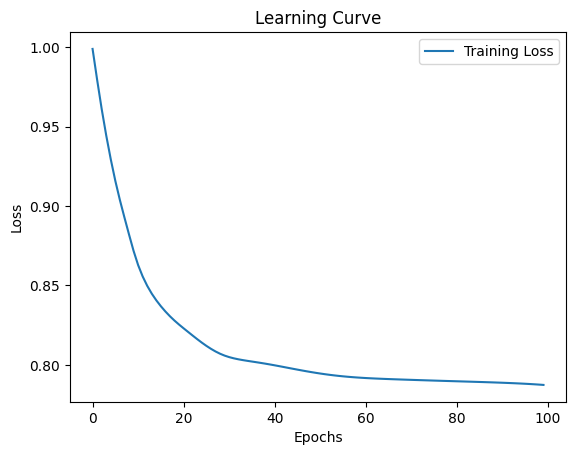

In [100]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [101]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8456221198156681
Precision: 0.8627450980392157
Recall: 0.8186046511627907
F1 Score: 0.8400954653937948


In [102]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

Test Accuracy: 0.8348623853211009
Test Precision: 0.8301886792452831
Test Recall: 0.8301886792452831
Test F1 Score: 0.8301886792452831


#### Predict T+

In [103]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [104]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.0379
Epoch [2/100], Loss: 1.0018
Epoch [3/100], Loss: 0.9709
Epoch [4/100], Loss: 0.9481
Epoch [5/100], Loss: 0.9309
Epoch [6/100], Loss: 0.9165
Epoch [7/100], Loss: 0.9033
Epoch [8/100], Loss: 0.8907
Epoch [9/100], Loss: 0.8789
Epoch [10/100], Loss: 0.8685
Epoch [11/100], Loss: 0.8597
Epoch [12/100], Loss: 0.8523
Epoch [13/100], Loss: 0.8460
Epoch [14/100], Loss: 0.8403
Epoch [15/100], Loss: 0.8351
Epoch [16/100], Loss: 0.8301
Epoch [17/100], Loss: 0.8253
Epoch [18/100], Loss: 0.8206
Epoch [19/100], Loss: 0.8160
Epoch [20/100], Loss: 0.8116
Epoch [21/100], Loss: 0.8074
Epoch [22/100], Loss: 0.8032
Epoch [23/100], Loss: 0.7994
Epoch [24/100], Loss: 0.7960
Epoch [25/100], Loss: 0.7933
Epoch [26/100], Loss: 0.7912
Epoch [27/100], Loss: 0.7896
Epoch [28/100], Loss: 0.7882
Epoch [29/100], Loss: 0.7871
Epoch [30/100], Loss: 0.7860
Epoch [31/100], Loss: 0.7849
Epoch [32/100], Loss: 0.7839
Epoch [33/100], Loss: 0.7829
Epoch [34/100], Loss: 0.7818
Epoch [35/100], Loss: 0

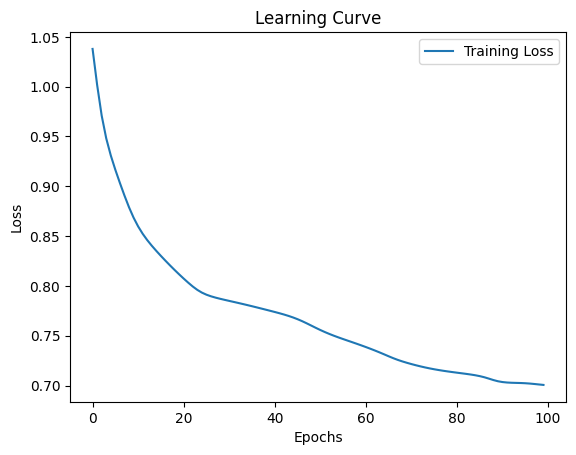

In [105]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [106]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.9174311926605505
Test Precision: 0.9464285714285714
Test Recall: 0.8983050847457628
Test F1 Score: 0.9217391304347826


In [107]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.9101382488479263
Precision: 0.9179487179487179
Recall: 0.8861386138613861
F1 Score: 0.9017632241813602


#### Predict N+

In [108]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [109]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.7782
Epoch [2/100], Loss: 1.7262
Epoch [3/100], Loss: 1.6675
Epoch [4/100], Loss: 1.6049
Epoch [5/100], Loss: 1.5477
Epoch [6/100], Loss: 1.4993
Epoch [7/100], Loss: 1.4550
Epoch [8/100], Loss: 1.4132
Epoch [9/100], Loss: 1.3710
Epoch [10/100], Loss: 1.3286
Epoch [11/100], Loss: 1.2869
Epoch [12/100], Loss: 1.2475
Epoch [13/100], Loss: 1.2128
Epoch [14/100], Loss: 1.1846
Epoch [15/100], Loss: 1.1625
Epoch [16/100], Loss: 1.1439
Epoch [17/100], Loss: 1.1257
Epoch [18/100], Loss: 1.1066
Epoch [19/100], Loss: 1.0872
Epoch [20/100], Loss: 1.0685
Epoch [21/100], Loss: 1.0513
Epoch [22/100], Loss: 1.0362
Epoch [23/100], Loss: 1.0243
Epoch [24/100], Loss: 1.0154
Epoch [25/100], Loss: 1.0079
Epoch [26/100], Loss: 1.0003
Epoch [27/100], Loss: 0.9920
Epoch [28/100], Loss: 0.9831
Epoch [29/100], Loss: 0.9743
Epoch [30/100], Loss: 0.9652
Epoch [31/100], Loss: 0.9548
Epoch [32/100], Loss: 0.9422
Epoch [33/100], Loss: 0.9277
Epoch [34/100], Loss: 0.9126
Epoch [35/100], Loss: 0

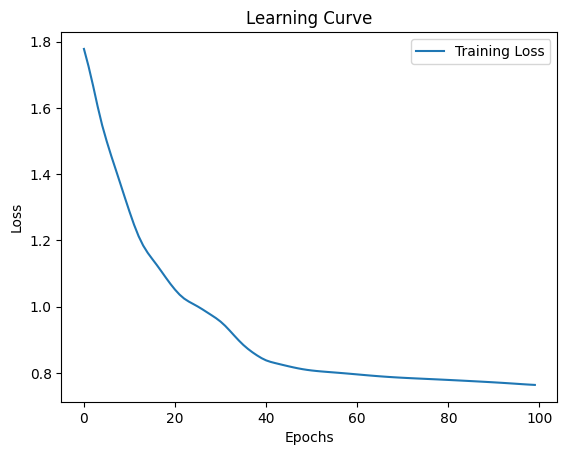

In [110]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [111]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8917050691244239
Precision: 0.8888888888888888
Recall: 0.865979381443299
F1 Score: 0.8772845953002611


In [112]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8990825688073395
Test Precision: 0.9245283018867925
Test Recall: 0.875
Test F1 Score: 0.8990825688073395


## MTL

#### CLASS

In [113]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)
    

In [114]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([434, 166]) torch.Size([109, 166]) torch.Size([434, 3]) torch.Size([109, 3])


In [115]:
model = MultitaskSVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.061911627281932204, weight_decay=8.933152146862321e-05)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.8129
Epoch [2/100], Loss: 1.6437
Epoch [3/100], Loss: 1.4430
Epoch [4/100], Loss: 1.2691
Epoch [5/100], Loss: 1.1592
Epoch [6/100], Loss: 1.0767
Epoch [7/100], Loss: 0.9967
Epoch [8/100], Loss: 0.9318
Epoch [9/100], Loss: 0.8874
Epoch [10/100], Loss: 0.8496
Epoch [11/100], Loss: 0.8151
Epoch [12/100], Loss: 0.8033
Epoch [13/100], Loss: 0.7931
Epoch [14/100], Loss: 0.7917
Epoch [15/100], Loss: 0.7935
Epoch [16/100], Loss: 0.7934
Epoch [17/100], Loss: 0.7930
Epoch [18/100], Loss: 0.7927
Epoch [19/100], Loss: 0.7918
Epoch [20/100], Loss: 0.7906
Epoch [21/100], Loss: 0.7887
Epoch [22/100], Loss: 0.7865
Epoch [23/100], Loss: 0.7842
Epoch [24/100], Loss: 0.7823
Epoch [25/100], Loss: 0.7809
Epoch [26/100], Loss: 0.7796
Epoch [27/100], Loss: 0.7781
Epoch [28/100], Loss: 0.7771
Epoch [29/100], Loss: 0.7766
Epoch [30/100], Loss: 0.7763
Epoch [31/100], Loss: 0.7757
Epoch [32/100], Loss: 0.7749
Epoch [33/100], Loss: 0.7740
Epoch [34/100], Loss: 0.7731
Epoch [35/100], Loss: 0

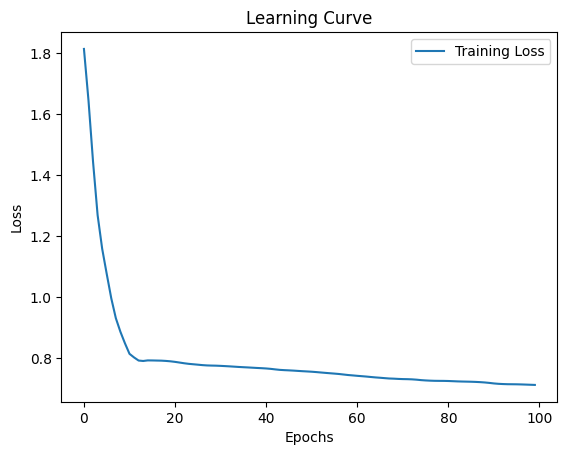

In [116]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [117]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    # For multitask (MTL) evaluation
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average='macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average='macro'))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np, average='macro') * recall_score(y_train_np, y_pred_np, average='macro')) /
          (precision_score(y_train_np, y_pred_np, average='macro') + recall_score(y_train_np, y_pred_np, average='macro')))


Accuracy: 0.8064516129032258
Precision: 0.9073507180650037
Recall: 0.8839906695056943
F1 Score: 0.8955183800297244


In [118]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np, average='macro') * recall_score(y_test_np,
                                                                  y_test_pred_np, average='macro')) / (
              precision_score(y_test_np, y_test_pred_np, average='macro') + recall_score(y_test_np,
                                                                        y_test_pred_np, average='macro')))

Test Accuracy: 0.7614678899082569
Test Precision: 0.9343737494997999
Test Recall: 0.8323511048167268
Test F1 Score: 0.8804166883232948


### MTL OPTIMISATION

In [119]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return plane_output

In [120]:



def objective(trial):

    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    #kernel_type = trial.suggest_categorical("kernel", ["RBF", "Matern", "RQ"])  # optional
    kernel_type = "RBF"
    num_epochs = 100

    if kernel_type == "RBF":
        kernel = gpytorch.kernels.RBFKernel()
    # elif kernel_type == "Matern":
    #     kernel = gpytorch.kernels.MaternKernel()
    # elif kernel_type == "RQ":
    #     kernel = gpytorch.kernels.RQKernel()
    # else:
    #     kernel = gpytorch.kernels.RBFKernel()  

    model = MultitaskSVM(X_train, y_train, kernel).to(device)
    loss_fn = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()


        if epoch % 10 == 0:
            trial.report(-loss.item(), step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy()
        true = y_test.cpu().numpy()


    preds_binary = (preds > 0).astype(int)
    true_binary = (true > 0).astype(int)


    f1_scores = [
        f1_score(true_binary[:, i], preds_binary[:, i]) for i in range(true.shape[1])
    ]
    mean_f1 = sum(f1_scores) / len(f1_scores)

    return mean_f1  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-07 10:53:50,483] A new study created in memory with name: no-name-bc57a9f0-fed9-4615-ac4b-4ded1e35ae5a
[I 2025-07-07 10:53:50,698] Trial 0 finished with value: 0.8850138815051096 and parameters: {'lr': 0.01354210317067808, 'weight_decay': 0.00046900623577598104}. Best is trial 0 with value: 0.8850138815051096.
[I 2025-07-07 10:53:50,901] Trial 1 finished with value: 0.8205527667185968 and parameters: {'lr': 0.0035570136488647878, 'weight_decay': 2.798062203915236e-05}. Best is trial 0 with value: 0.8850138815051096.
[I 2025-07-07 10:53:51,115] Trial 2 finished with value: 0.6684232898530684 and parameters: {'lr': 0.0005811300306973604, 'weight_decay': 0.000889458508598171}. Best is trial 0 with value: 0.8850138815051096.
[I 2025-07-07 10:53:51,343] Trial 3 finished with value: 0.8769279592371163 and parameters: {'lr': 0.07781385338420838, 'weight_decay': 0.0003461858668330954}. Best is trial 0 with value: 0.8850138815051096.
[I 2025-07-07 10:53:51,566] Trial 4 finished with 

Best trial:
  F1 Score: 0.8850138815051096
  Params: 
    lr: 0.01354210317067808
    weight_decay: 0.00046900623577598104


# Sensitivity Test



class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super().__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [4]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()
        
    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [5]:
data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))

df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)

df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

df.head()
X = df.drop(columns=['A+', 'T+', 'N+'])

In [6]:

y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([434, 166]) torch.Size([109, 166]) torch.Size([434, 3]) torch.Size([109, 3])


Epoch [1/100], Loss: 1.2801
Epoch [2/100], Loss: 1.2363
Epoch [3/100], Loss: 1.1973
Epoch [4/100], Loss: 1.1595
Epoch [5/100], Loss: 1.1187
Epoch [6/100], Loss: 1.0791
Epoch [7/100], Loss: 1.0418
Epoch [8/100], Loss: 1.0087
Epoch [9/100], Loss: 0.9798
Epoch [10/100], Loss: 0.9547
Epoch [11/100], Loss: 0.9349
Epoch [12/100], Loss: 0.9190
Epoch [13/100], Loss: 0.9042
Epoch [14/100], Loss: 0.8904
Epoch [15/100], Loss: 0.8783
Epoch [16/100], Loss: 0.8678
Epoch [17/100], Loss: 0.8586
Epoch [18/100], Loss: 0.8507
Epoch [19/100], Loss: 0.8442
Epoch [20/100], Loss: 0.8388
Epoch [21/100], Loss: 0.8344
Epoch [22/100], Loss: 0.8306
Epoch [23/100], Loss: 0.8273
Epoch [24/100], Loss: 0.8243
Epoch [25/100], Loss: 0.8214
Epoch [26/100], Loss: 0.8188
Epoch [27/100], Loss: 0.8162
Epoch [28/100], Loss: 0.8139
Epoch [29/100], Loss: 0.8116
Epoch [30/100], Loss: 0.8096
Epoch [31/100], Loss: 0.8076
Epoch [32/100], Loss: 0.8058
Epoch [33/100], Loss: 0.8041
Epoch [34/100], Loss: 0.8025
Epoch [35/100], Loss: 0

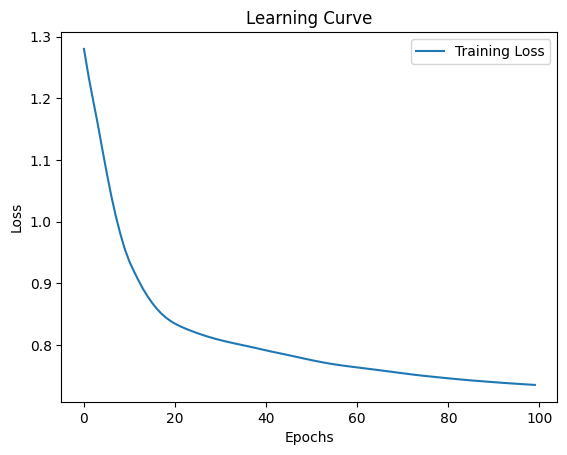

In [7]:
model = MultitaskSVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')
    
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [8]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("TRAIN:")
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average = 'macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average = 'macro'))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np, average = 'macro') * recall_score(y_train_np, y_pred_np, average = 'macro')) / (precision_score(y_train_np, y_pred_np, average = 'macro') + recall_score(y_train_np, y_pred_np, average = 'macro')))

TRAIN:
Accuracy: 0.7557603686635944
Precision: 0.9006088183027995
Recall: 0.8507340880335935
F1 Score: 0.8749612870692486


In [9]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("TEST:")
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

TEST:
Test Accuracy: 0.7155963302752294


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [10]:
def evaluate_with_margin_filter(model, X_test, y_test, epsilon=0.0):
    
    
    
    model.eval()
    with torch.no_grad():
        probs = model(X_test).squeeze() 
        
        confidence = torch.abs(probs - 0.5)  

        confidence_np = confidence.cpu().numpy()
        cutoff = np.percentile(confidence_np, 100 * epsilon)  
        mask = confidence > cutoff

        if mask.sum() == 0:
            print(f"No samples left after applying epsilon = {epsilon:.2f} (cutoff = {cutoff:.4f})")
            return None, None, None, None, None

        y_filtered = y_test[mask]
        probs_filtered = probs[mask]
        y_pred = (probs_filtered > 0.5).float()

        y_pred_np = y_pred.cpu().numpy()
        y_true_np = y_filtered.cpu().numpy()
        y_probs_np = probs_filtered.cpu().numpy()

        accuracy = accuracy_score(y_true_np, y_pred_np)
        precision = precision_score(y_true_np, y_pred_np, average = 'macro')
        recall = recall_score(y_true_np, y_pred_np, average = 'macro')
        f1 = f1_score(y_true_np, y_pred_np, average = 'macro')
        coverage = mask.float().mean().item()
        auc = roc_auc_score(y_true_np, y_probs_np)
        fpr, tpr, _ = roc_curve(y_true_np, y_probs_np)

        coverage = mask.float().mean().item()

        print(f"\nEvaluation with epsilon = {epsilon:.2f} (Removed {epsilon:.0%} least confident, Coverage: {coverage:.2%})")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"AUROC:     {auc:.4f}")

        # Plot ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (epsilon = {epsilon:.2f})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return accuracy, precision, recall, f1, auc


Evaluation with epsilon = 0.00 (Removed 0% least confident, Coverage: 99.69%)
Accuracy:  0.8620
Precision: 0.8637
Recall:    0.8629
F1 Score:  0.8619
AUROC:     0.9380


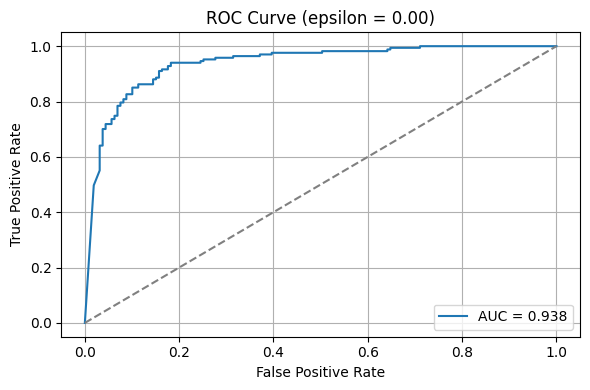

(0.8619631901840491,
 0.8637496224705528,
 0.8628591872858058,
 0.8619307112403648,
 0.9379542801190072)

In [11]:
evaluate_with_margin_filter(model, X_test,y_test, epsilon=0.0)


Evaluation with epsilon = 0.00 (Removed 0% least confident, Coverage: 99.69%)
Accuracy:  0.8620
Precision: 0.8637
Recall:    0.8629
F1 Score:  0.8619
AUROC:     0.9380


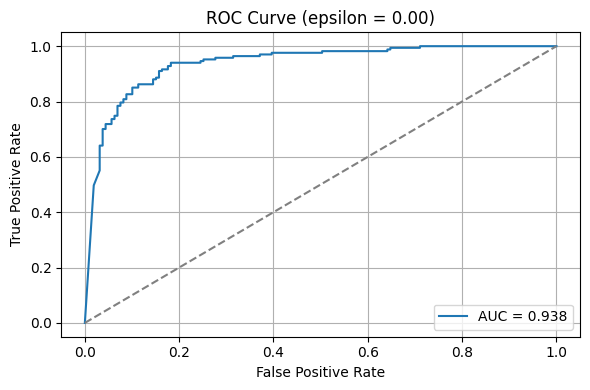


Evaluation with epsilon = 0.01 (Removed 1% least confident, Coverage: 98.78%)
Accuracy:  0.8700
Precision: 0.8716
Recall:    0.8707
F1 Score:  0.8699
AUROC:     0.9391


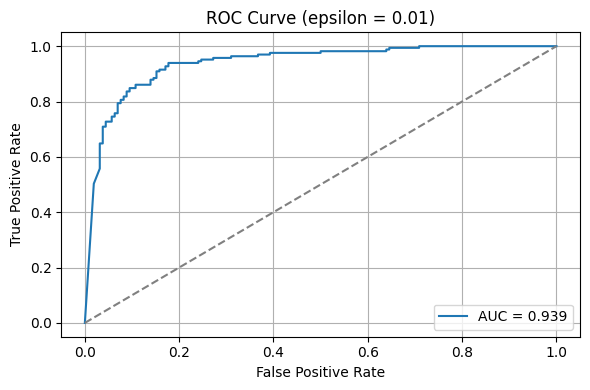


Evaluation with epsilon = 0.02 (Removed 2% least confident, Coverage: 97.86%)
Accuracy:  0.8781
Precision: 0.8795
Recall:    0.8787
F1 Score:  0.8781
AUROC:     0.9401


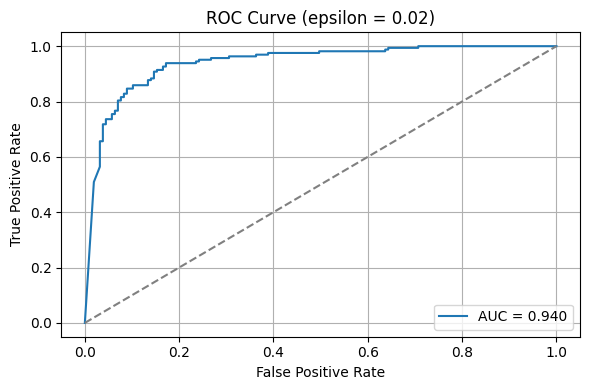


Evaluation with epsilon = 0.03 (Removed 3% least confident, Coverage: 96.94%)
Accuracy:  0.8770
Precision: 0.8783
Recall:    0.8777
F1 Score:  0.8770
AUROC:     0.9415


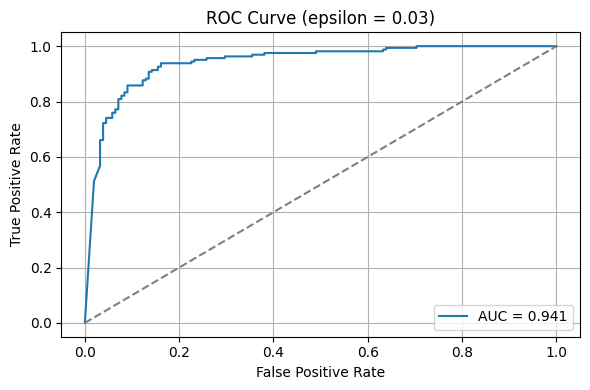


Evaluation with epsilon = 0.05 (Removed 5% least confident, Coverage: 94.80%)
Accuracy:  0.8839
Precision: 0.8859
Recall:    0.8844
F1 Score:  0.8838
AUROC:     0.9437


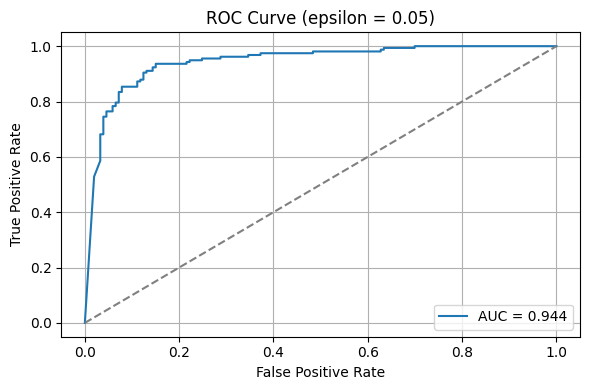


Evaluation with epsilon = 0.10 (Removed 10% least confident, Coverage: 89.91%)
Accuracy:  0.8878
Precision: 0.8906
Recall:    0.8881
F1 Score:  0.8876
AUROC:     0.9495


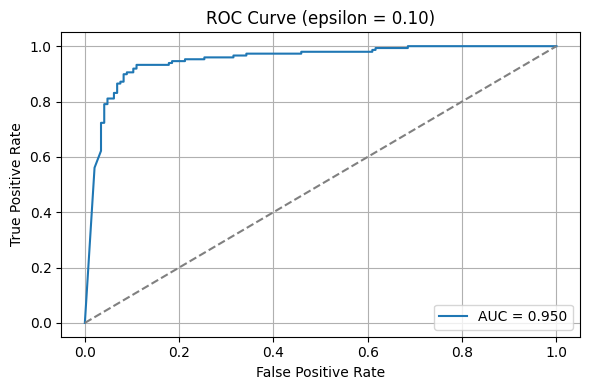


Evaluation with epsilon = 0.15 (Removed 15% least confident, Coverage: 85.02%)
Accuracy:  0.9137
Precision: 0.9147
Recall:    0.9132
F1 Score:  0.9135
AUROC:     0.9532


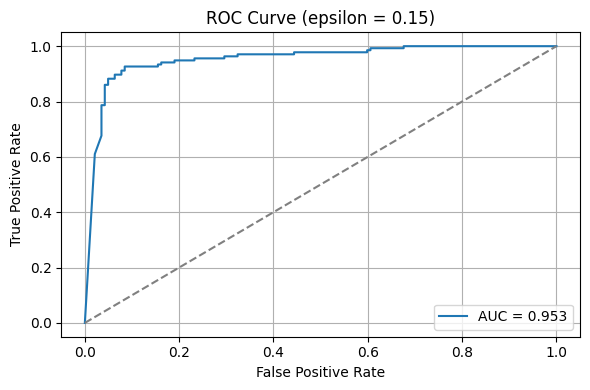


Evaluation with epsilon = 0.20 (Removed 20% least confident, Coverage: 79.82%)
Accuracy:  0.9387
Precision: 0.9394
Recall:    0.9381
F1 Score:  0.9385
AUROC:     0.9563


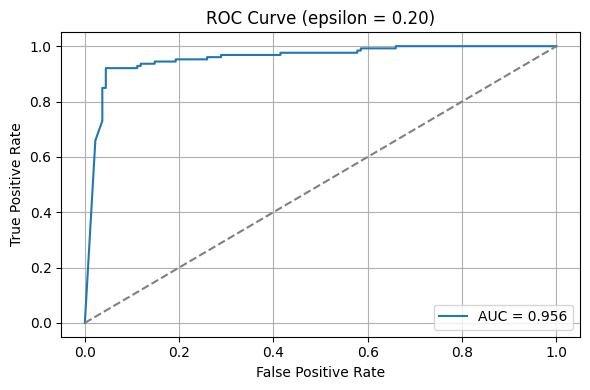


Evaluation with epsilon = 0.25 (Removed 25% least confident, Coverage: 74.92%)
Accuracy:  0.9347
Precision: 0.9355
Recall:    0.9340
F1 Score:  0.9345
AUROC:     0.9590


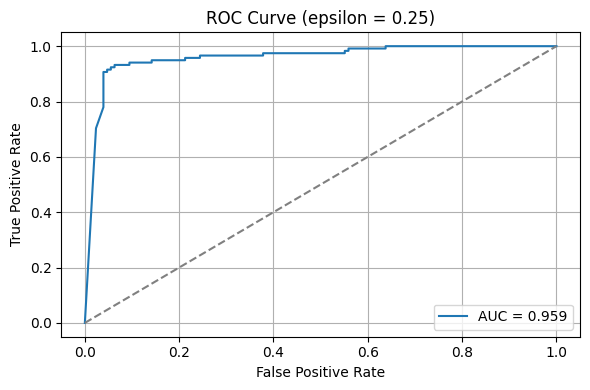


Evaluation with epsilon = 0.30 (Removed 30% least confident, Coverage: 70.03%)
Accuracy:  0.9476
Precision: 0.9479
Recall:    0.9471
F1 Score:  0.9474
AUROC:     0.9612


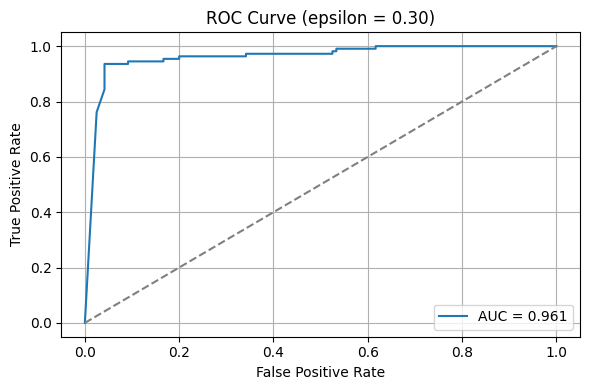


Evaluation with epsilon = 0.35 (Removed 35% least confident, Coverage: 64.83%)
Accuracy:  0.9481
Precision: 0.9482
Recall:    0.9478
F1 Score:  0.9480
AUROC:     0.9637


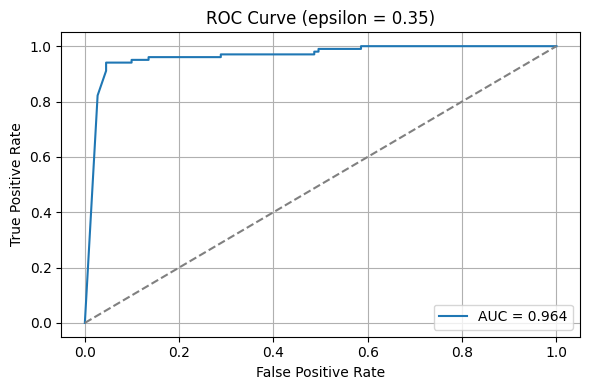


Evaluation with epsilon = 0.40 (Removed 40% least confident, Coverage: 56.88%)
Accuracy:  0.9624
Precision: 0.9626
Recall:    0.9619
F1 Score:  0.9622
AUROC:     0.9672


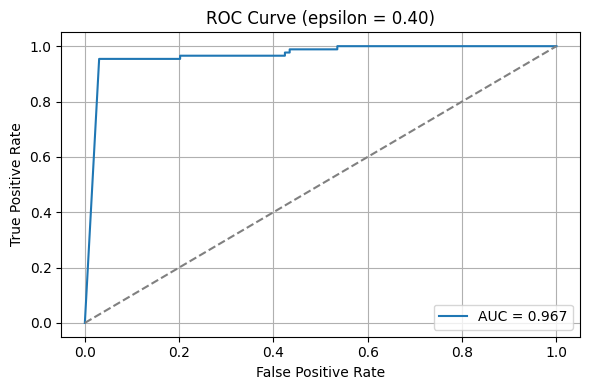


Evaluation with epsilon = 0.45 (Removed 45% least confident, Coverage: 54.13%)
Accuracy:  0.9605
Precision: 0.9606
Recall:    0.9603
F1 Score:  0.9604
AUROC:     0.9685


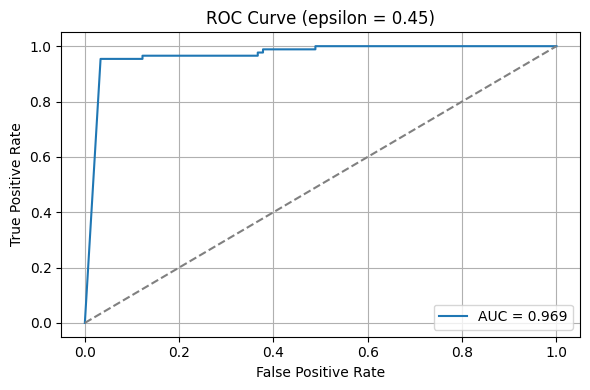

No samples left after applying epsilon = 0.50 (cutoff = 0.5000)


In [12]:
accuracy = []
precision = []
recall = []
f1 = []
auroc = []
epsilon = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
for eps in epsilon:
    a, p, r, f, aur = evaluate_with_margin_filter(model, X_test, y_test, epsilon=eps)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    f1.append(f)
    auroc.append(aur)

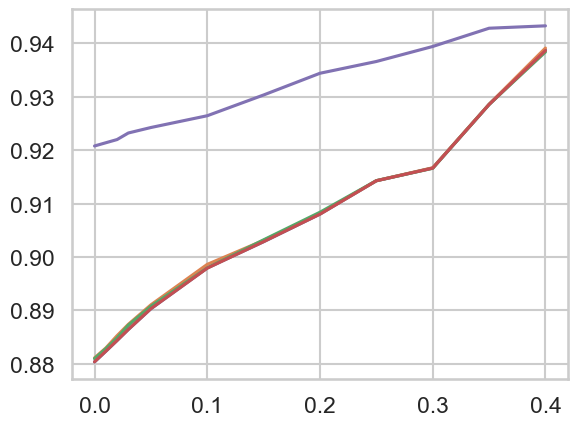

In [34]:
plt.plot(epsilon, accuracy)
plt.plot(epsilon, precision)
plt.plot(epsilon, recall)
plt.plot(epsilon, f1)
plt.plot(epsilon, auroc)

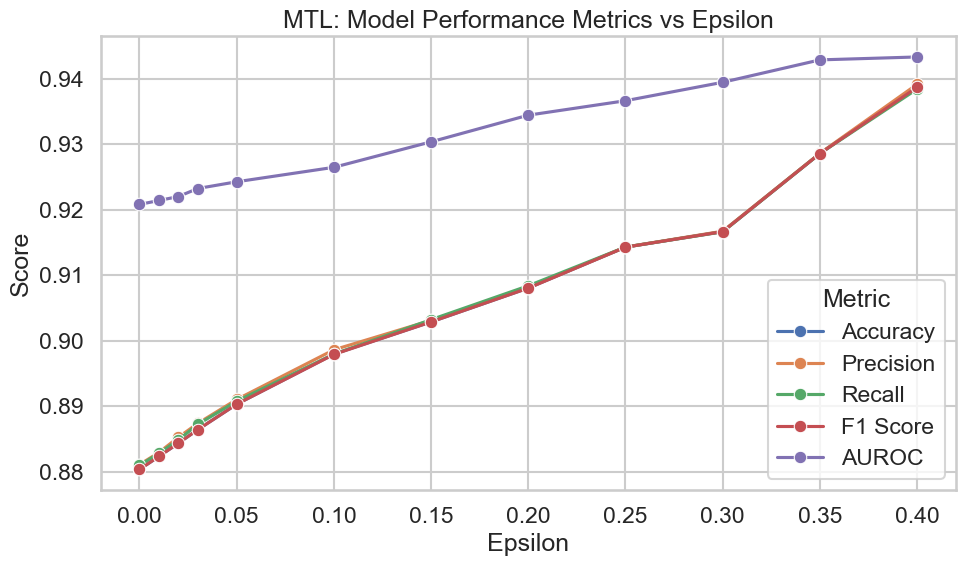

In [36]:
df = pd.DataFrame({
    'epsilon': epsilon,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUROC': auroc
})

df_long = df.melt(id_vars='epsilon', var_name='Metric', value_name='Score')

# Step 2: Plot using seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", context="talk")
sns.lineplot(data=df_long, x='epsilon', y='Score', hue='Metric', marker="o")

# Step 3: Customize
plt.title('MTL: Model Performance Metrics vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()